In [109]:
import mlxtend
import numpy as np
import pandas as pd
import re

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import time

from scipy import stats
from numpy.linalg import norm

from sklearn.cluster import KMeans, DBSCAN
from sklearn.cluster import k_means_

from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity, cosine_distances
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler  # For scaling dataset
from sklearn.metrics import silhouette_score

import seaborn as sns; sns.set(style="ticks", color_codes=True)

# Resumo

O objetivo deste notbook é executar o trablho da disciplina de Data Mining I. O enunciado pedia que:

# Importando o dataset

dataset depois do tratamento feito para a análise de Market Basket. 

In [2]:
ratingsDF_100k = pd.read_pickle("..\\ProcessedData\\df.pkl")
ratingsDF_1M = pd.read_pickle("..\\ProcessedData\\df_1M.pkl")

visualizando dataset 100k

In [3]:
ratingsDF_100k.head()

uid   id rating           timestamp   movie_title release_date  \
0  196  242      3 1997-12-04 15:55:49  Kolya (1996)   1997-01-24   
1   63  242      3 1997-10-01 23:06:30  Kolya (1996)   1997-01-24   
2  226  242      5 1998-01-04 04:37:51  Kolya (1996)   1997-01-24   
3  154  242      3 1997-11-10 05:03:55  Kolya (1996)   1997-01-24   
4  306  242      5 1997-10-10 17:16:33  Kolya (1996)   1997-01-24   

                                          IMDb_URL unknown Action Adventure  \
0  http://us.imdb.com/M/title-exact?Kolya%20(1996)       0      0         0   
1  http://us.imdb.com/M/title-exact?Kolya%20(1996)       0      0         0   
2  http://us.imdb.com/M/title-exact?Kolya%20(1996)       0      0         0   
3  http://us.imdb.com/M/title-exact?Kolya%20(1996)       0      0         0   
4  http://us.imdb.com/M/title-exact?Kolya%20(1996)       0      0         0   

    ...   Fantasy Film-Noir Horror Musical Mystery Romance Sci-Fi Thriller  \
0   ...         0         0      0       0       0       0      0        0   
1   ...         0         0      0       0       0       0      0        0   
2   ...         0         0      0       0       0       0      0        0   
3   ...         0         0      0       0       0       0      0        0   
4   ...         0         0      0       0       0       0      0        0   

  War Western  
0   0       0  
1   0       0  
2   0       0  
3   0       0  
4   0       0  

[5 rows x 26 columns]

visualizando dataset 1M

In [4]:
ratingsDF_1M.head()

uid    id rating           timestamp  \
0    1  1193      5 2000-12-31 22:12:40   
1    2  1193      5 2000-12-31 21:33:33   
2   12  1193      4 2000-12-30 23:49:39   
3   15  1193      4 2000-12-30 18:01:19   
4   17  1193      5 2000-12-30 06:41:11   

                              movie_title Genres  
0  ONE FLEW OVER THE CUCKOO'S NEST (1975)  Drama  
1  ONE FLEW OVER THE CUCKOO'S NEST (1975)  Drama  
2  ONE FLEW OVER THE CUCKOO'S NEST (1975)  Drama  
3  ONE FLEW OVER THE CUCKOO'S NEST (1975)  Drama  
4  ONE FLEW OVER THE CUCKOO'S NEST (1975)  Drama

In [5]:
print("Número de usuários na base 100k %i" % ratingsDF_100k['uid'].nunique())
print("Número de usuários na base 1M %i" % ratingsDF_1M['uid'].nunique())

Número de usuários na base 100k 943
Número de usuários na base 1M 6040


In [6]:
print("Número de filmes na base 100k %i" % ratingsDF_100k['id'].nunique())
print("Número de filmes na base 1M %i" % ratingsDF_1M['id'].nunique())

Número de filmes na base 100k 1664
Número de filmes na base 1M 3706


## Criando os vetores de features dos filmes

Cada filme será representado pelas notas que cada um dos usuários da base deu para aquele filme. O que siginifica que **cada filme será representado por vetores esparsos de tamanho 943**.

Sabemos da exploração que não há duplicatas para a chave **uid, id**, então:

In [7]:
def visualize_ratings_sparsity(ratingsDF):
    ratings_id = ratingsDF.groupby(['id']).aggregate({'rating': len})
    
    print("Moda do número de usuários que viram o filme: %i" % ratings_id.rating.mode())
    print("Média do número de usuários que viram o filme: %i" % ratings_id.rating.mean())
    print("Número de filmes com apenas uma avaliação: %i" % (ratings_id.rating == 1).sum())
    
    plt.figure(),
    plt.subplot(1,2,1)
    ratings_id.rating.hist()
    plt.grid(True)
    plt.title("#usuários que viram o filme")
    plt.xlabel("uid")
    plt.ylabel("freq absoluta")

    plt.subplot(1,2,2)
    ratings_id.boxplot()
    plt.title("Boxplot que viram o filme")
    plt.rcParams['figure.figsize'] = (11,7)
    plt.show()
    
    return ratings_id

Esparsidade do vetor de features na base de 100k 

Moda do número de usuários que viram o filme: 1
Média do número de usuários que viram o filme: 59
Número de filmes com apenas uma avaliação: 135


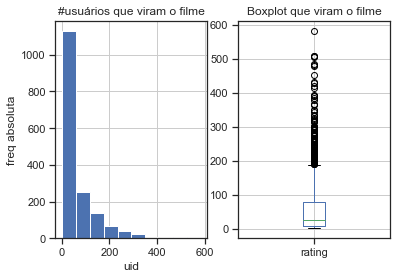

In [8]:
ratings_id_100k = visualize_ratings_sparsity(ratingsDF_100k)

Esparsidade do vetor de features na base de 1M 

Moda do número de usuários que viram o filme: 1
Média do número de usuários que viram o filme: 269
Número de filmes com apenas uma avaliação: 114


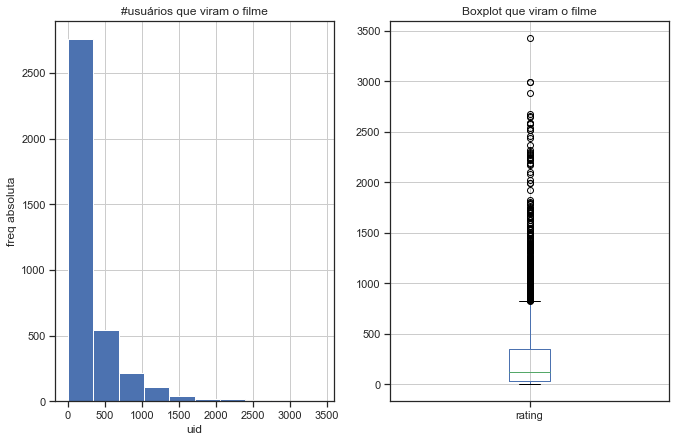

In [9]:
ratings_id_1M = visualize_ratings_sparsity(ratingsDF_1M)

## Filmes mais vistos

Para depois acharmos quais so clusters dos filmes mais populares vamos determinar quais sã eles primeiro. Após a observação dos box plot que mostram o quão esparsos são os vetores das bases, pode-se considerar que um filme popular na base de 100k tem pelo meos 150 visualizações e na base de 1M pelo menos 750

In [10]:
def determine_popular_filmss(ratings_id, threshold):
    popular_film = (ratings_id.rating > threshold)
    popular_ids = popular_film[popular_film]
    print("número de filmes populares %i" % popular_film.sum())
    return popular_ids

Para a base de 100k

In [11]:
popular_ids_100k = popular_ids_100k = determine_popular_filmss(ratings_id_100k, 150)

número de filmes populares 202


In [12]:
ratingsDF_100k[ratingsDF_100k['id'].isin(popular_ids_100k.index)].sample(10)

uid   id rating           timestamp  \
787    780  474      3 1998-03-31 17:02:03   
39970  194  410      3 1997-11-14 20:57:22   
36655  669  357      4 1998-03-30 12:23:36   
56787  429  284      3 1997-12-17 19:20:24   
23367  703  323      2 1997-09-26 02:51:21   
48912  246  211      4 1998-01-16 03:50:05   
45603  385  176      2 1997-11-13 17:16:26   
71039  787  319      3 1998-03-04 02:48:41   
46630   28  173      3 1997-12-12 19:50:20   
28900  344  228      4 1998-01-15 21:50:47   

                                             movie_title release_date  \
787    Dr. Strangelove or: How I Learned to Stop Worr...   1963-01-01   
39970                                     Kingpin (1996)   1996-07-12   
36655             One Flew Over the Cuckoo's Nest (1975)   1975-01-01   
56787                                     Tin Cup (1996)   1996-08-16   
23367                                Dante's Peak (1997)   1997-02-07   
48912                                     M*A*S*H (1970)   1970-01-01   
45603                                      Aliens (1986)   1986-01-01   
71039                    Everyone Says I Love You (1996)   1996-12-06   
46630                         Princess Bride, The (1987)   1987-01-01   
28900                Star Trek: The Wrath of Khan (1982)   1982-01-01   

                                                IMDb_URL unknown Action  \
787    http://us.imdb.com/M/title-exact?Dr.%20Strange...       0      0   
39970  http://us.imdb.com/M/title-exact?Kingpin%20(1996)       0      0   
36655  http://us.imdb.com/M/title-exact?One%20Flew%20...       0      0   
56787  http://us.imdb.com/M/title-exact?Tin%20Cup%20(...       0      0   
23367  http://us.imdb.com/M/title-exact?Dante's%20Pea...       0      1   
48912     http://us.imdb.com/M/title-exact?MASH%20(1970)       0      0   
45603   http://us.imdb.com/M/title-exact?Aliens%20(1986)       0      1   
71039  http://us.imdb.com/M/title-exact?Everyone%20Sa...       0      0   
46630  http://us.imdb.com/M/title-exact?Princess%20Br...       0      1   
28900  http://us.imdb.com/M/title-exact?Star%20Trek:%...       0      1   

      Adventure   ...   Fantasy Film-Noir Horror Musical Mystery Romance  \
787           0   ...         0         0      0       0       0       0   
39970         0   ...         0         0      0       0       0       0   
36655         0   ...         0         0      0       0       0       0   
56787         0   ...         0         0      0       0       0       1   
23367         0   ...         0         0      0       0       0       0   
48912         0   ...         0         0      0       0       0       0   
45603         0   ...         0         0      0       0       0       0   
71039         0   ...         0         0      0       1       0       1   
46630         1   ...         0         0      0       0       0       1   
28900         1   ...         0         0      0       0       0       0   

      Sci-Fi Thriller War Western  
787        1        0   1       0  
39970      0        0   0       0  
36655      0        0   0       0  
56787      0        0   0       0  
23367      0        1   0       0  
48912      0        0   1       0  
45603      1        1   1       0  
71039      0        0   0       0  
46630      0        0   0       0  
28900      1        0   0       0  

[10 rows x 26 columns]

In [13]:
popular_ids_1M = popular_ids_100k = determine_popular_filmss(ratings_id_1M, 750)

número de filmes populares 354


In [14]:
ratingsDF_1M[ratingsDF_1M['id'].isin(popular_ids_1M.index)].sample(10)

uid    id rating           timestamp  \
238989  2611    47      4 2000-11-09 19:48:21   
3358    2095  3408      5 2000-11-19 17:04:08   
649561   602  1748      3 2000-12-03 21:13:45   
18454   5964  2791      4 2000-04-29 07:39:30   
117980  3035   480      3 2000-09-30 00:32:41   
347416  1024  1674      5 2000-11-23 18:23:17   
722574  5890  3210      4 2000-05-04 20:19:35   
241758  2455   296      5 2000-11-14 05:31:41   
415775  5735   778      5 2000-05-15 20:20:58   
753571  3167  3424      5 2000-09-13 04:14:48   

                                movie_title                     Genres  
238989                 SEVEN (SE7EN) (1995)             Crime|Thriller  
3358                 ERIN BROCKOVICH (2000)                      Drama  
649561                     DARK CITY (1998)  Film-Noir|Sci-Fi|Thriller  
18454                      AIRPLANE! (1980)                     Comedy  
117980                 JURASSIC PARK (1993)    Action|Adventure|Sci-Fi  
347416                       WITNESS (1985)     Drama|Romance|Thriller  
722574  FAST TIMES AT RIDGEMONT HIGH (1982)                     Comedy  
241758                  PULP FICTION (1994)                Crime|Drama  
415775                 TRAINSPOTTING (1996)                      Drama  
753571            DO THE RIGHT THING (1989)               Comedy|Drama

# Criando vetores de features

Para fins desse trabalho, foi pedido para que usássemos as notas dadas pelos uuários como features. Outra informaçoes contidas na base poderiam ser usadas como: ano de lançamento e gênero.

In [15]:
def create_features(ratingsDF):
    df_pivoted = pd.pivot_table(ratingsDF, columns=['uid'], values=['rating'], index=['id'], aggfunc=np.max)
    df_pivoted.columns = df_pivoted.columns.get_level_values(1)
    return df_pivoted

In [16]:
%%time
df_features_100k = create_features(ratingsDF_100k)

Wall time: 1min 13s


In [17]:
df_features_100k.head(10)

uid  1    2    3    4    5    6    7    8    9    10  ...   934  935  936  \
id                                                    ...                   
1    5.0  4.0  NaN  NaN  4.0  4.0  NaN  NaN  NaN  4.0 ...   2.0  3.0  4.0   
2    3.0  NaN  NaN  NaN  3.0  NaN  NaN  NaN  NaN  NaN ...   4.0  NaN  NaN   
3    4.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   NaN  NaN  4.0   
4    3.0  NaN  NaN  NaN  NaN  NaN  5.0  NaN  NaN  4.0 ...   5.0  NaN  NaN   
5    3.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   NaN  NaN  NaN   
6    5.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  5.0  NaN ...   NaN  NaN  5.0   
7    4.0  NaN  NaN  NaN  NaN  2.0  5.0  3.0  4.0  4.0 ...   NaN  NaN  4.0   
8    1.0  NaN  NaN  NaN  NaN  4.0  5.0  NaN  NaN  NaN ...   NaN  NaN  NaN   
9    5.0  NaN  NaN  NaN  NaN  4.0  5.0  NaN  NaN  4.0 ...   NaN  1.0  4.0   
10   3.0  2.0  NaN  NaN  NaN  NaN  4.0  NaN  NaN  NaN ...   NaN  NaN  NaN   

uid  937  938  939  940  941  942  943  
id                                      
1    NaN  4.0  NaN  NaN  5.0  NaN  NaN  
2    NaN  NaN  NaN  NaN  NaN  NaN  5.0  
3    NaN  NaN  NaN  NaN  NaN  NaN  NaN  
4    NaN  NaN  NaN  2.0  NaN  NaN  NaN  
5    NaN  NaN  NaN  NaN  NaN  NaN  NaN  
6    NaN  NaN  NaN  NaN  NaN  NaN  NaN  
7    NaN  4.0  NaN  4.0  4.0  NaN  NaN  
8    NaN  NaN  NaN  5.0  NaN  NaN  NaN  
9    5.0  3.0  5.0  3.0  NaN  NaN  3.0  
10   NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[10 rows x 943 columns]

In [18]:
%%time
df_features_1M = create_features(ratingsDF_1M)

Wall time: 11min 42s


In [19]:
df_features_1M.head(10)

uid  1     2     3     4     5     6     7     8     9     10    ...   6031  \
id                                                               ...          
1     5.0   NaN   NaN   NaN   NaN   4.0   NaN   4.0   5.0   5.0  ...    NaN   
2     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   5.0  ...    NaN   
3     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    NaN   
4     NaN   NaN   NaN   NaN   NaN   NaN   NaN   3.0   NaN   NaN  ...    NaN   
5     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    NaN   
6     NaN   NaN   NaN   NaN   2.0   NaN   4.0   NaN   NaN   NaN  ...    NaN   
7     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   4.0  ...    NaN   
8     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    5.0   
9     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    NaN   
10    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    NaN   

uid  6032  6033  6034  6035  6036  6037  6038  6039  6040  
id                                                         
1     4.0   NaN   NaN   4.0   NaN   NaN   NaN   NaN   3.0  
2     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
3     NaN   NaN   NaN   1.0   NaN   NaN   NaN   NaN   NaN  
4     NaN   NaN   NaN   2.0   2.0   NaN   NaN   NaN   NaN  
5     NaN   NaN   NaN   1.0   NaN   NaN   NaN   NaN   NaN  
6     NaN   NaN   NaN   NaN   3.0   NaN   NaN   NaN   NaN  
7     NaN   NaN   NaN   3.0   NaN   NaN   NaN   NaN   NaN  
8     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
9     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
10    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[10 rows x 6040 columns]

In [286]:
# para evitar o retreino das features que pode demorar um pouco especialmete para a base de 1M
df_features_100k.to_pickle('../ProcessedData/temp/df_features_100k.pkl')
df_features_1M.to_pickle('../ProcessedData/temp/df_features_1M.pkl')

In [20]:
# para evitar o retreino das features que pode demorar um pouco especialmete para a base de 1M
df_features_100k = pd.read_pickle('../ProcessedData/temp/df_features_100k.pkl')
df_features_1M = pd.read_pickle('../ProcessedData/temp/df_features_1M.pkl')

## Fill de valores nulos

Os algoritimos que vamos utilizar são sensíveis aos valores nulos. Para diminuir esse efeito, podemos substituir zeros pela média das notas dos filmes desconsiderando os valores 0 (que são NAN na verdade);

In [21]:
def fillNa_with_non_na_avg_rating_for_film(df_pivoted): 
    # Obs: a função *fillna* por linha não está implementada no Pandas, por isso as transposições
    filmMeanRating = df_pivoted.mean(axis=1)
    df_pivoted_ = df_pivoted.T.fillna(filmMeanRating).T
    return df_pivoted_

In [22]:
%%time
df_features_100k_filled_avg = fillNa_with_non_na_avg_rating_for_film(df_features_100k)

Wall time: 282 ms


In [23]:
%%time
df_features_1M_filled_avg = fillNa_with_non_na_avg_rating_for_film(df_features_1M)

Wall time: 722 ms


O data to enrich, será usado para mostrar os nomes e outras informações cadastrais dos filmes

## Base Cadastral

In [83]:
def enrich_columns(df, to_enrich):
#     df_full = pd.concat([df, to_enrich], axis=0, join='inner')
    df_ = df.copy()
    df_['id'] = to_enrich['id']
    df_full = df_.join(to_enrich, how='left', rsuffix='r')    
    df_full.drop(columns=['idr'], inplace=True)
#     df_full[df_full['cluster'] == 0].head(10)
#     df_full = df_full.rename(mapper={0:'pca_0', 1:'pca_1', 2:'pca_2'}, axis='columns')
    return df_full

In [77]:
to_enrich_100k = ratingsDF_100k.groupby('id').agg(
    {'timestamp':'first',
     'id':'first',
     'movie_title':'first', 
     'release_date':'first',
     'unknown':'first', 
     'Action':'first', 
     'Adventure':'first', 
     'Animation':'first', 
     'Children\'s':'first',
       'Comedy':'first', 
     'Crime':'first', 
     'Documentary':'first', 
     'Drama':'first', 
     'Fantasy':'first', 
     'Film-Noir':'first',
       'Horror':'first', 
     'Musical':'first', 
     'Mystery':'first', 
     'Romance':'first', 
     'Sci-Fi':'first', 
     'Thriller':'first', 
     'War':'first',
    'Western':'first'
    })

In [223]:
to_enrich_1M = ratingsDF_1M.groupby('id').agg(
    {'timestamp':'first', 
     'id':'first',
     'movie_title':'first', 
     'Genres':'first',
    })

# vetores de features e redução de dimensionalidade

In [26]:
def eevaluate_info_gain(df):
    all_info = []
    for c in df.columns:
        all_but_one = df.drop(columns=[c]).values
        one = df[c].values
        info = mutual_info_regression(X=all_but_one, y=one)
        all_info.append(info)
    return pd.DataFrame(data=all_info)

In [27]:
def get_pca(df_flattern, pca_dim):
    
    pca = PCA(n_components=pca_dim).fit(df_flattern)
    df_pca = pd.DataFrame(pca.transform(df_flattern))
    
    return df_pca, pca

def visualize_pca(df_pca, pca):
    pca_dim = pca.n_components
    cumulativeVar = pd.Series(pca.explained_variance_ratio_.cumsum())
    
    plt.figure()
    cumulativeVar.plot()
    
    plt.grid(True)
    plt.title("soma cumulativa das variâncias")
    plt.xlabel("#PCA components")
    plt.ylabel("variância")
    plt.show()
    
    # plt.figure().gca(projection='3d')
    plt.figure()
    plt.scatter(df_pca[0], df_pca[1])
    plt.grid(True)
    plt.title("filmes")
    plt.xlabel("pca_0")
    plt.ylabel("pca_1")
    plt.show()

## (Train, Test) split

Antes de transformar os dados, deve-se separar os dados para que não haja "nformation leak"

In [183]:
X_train_100k, X_test_100k = train_test_split( df_features_100k_filled_avg, test_size=0.2)
X_train_1M, X_test_1M = train_test_split( df_features_1M_filled_avg, test_size=0.2)

In [184]:
X_train_100k_idx =  X_train_100k.index
X_test_100k_idx =  X_test_100k.index

X_train_1M_idx =  X_train_1M.index
X_test_1M_idx =  X_test_1M.index

In [185]:
X_train_sparse_100k = df_features_100k.loc[X_train_100k_idx]
X_test_sparse_100k = df_features_100k.loc[X_train_100k_idx]

X_train_sparse_1M = df_features_1M.loc[X_train_1M_idx]
X_test_sparse_1M = df_features_1M.loc[X_train_1M_idx]

In [175]:
print("shape dos dados de treino: ", X_train_100k.shape)
print("shape dos dados de teste: ", X_test_100k.shape)

shape dos dados de treino:  (1331, 943)
shape dos dados de teste:  (333, 943)


## PCA para a base de 100K

In [155]:
X_pca_100k, pca_full_100k = get_pca(X_train_100k, None)

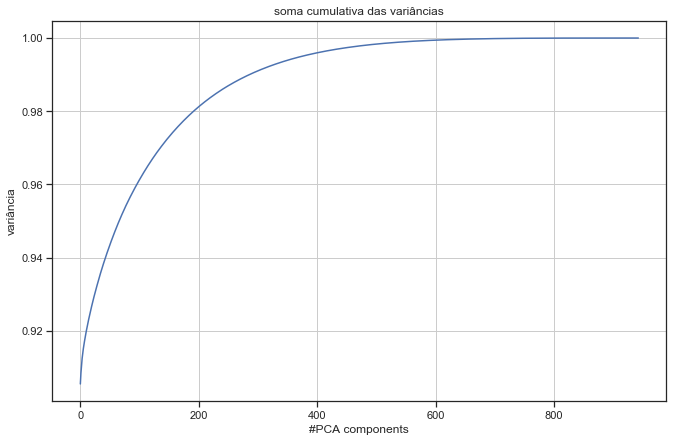

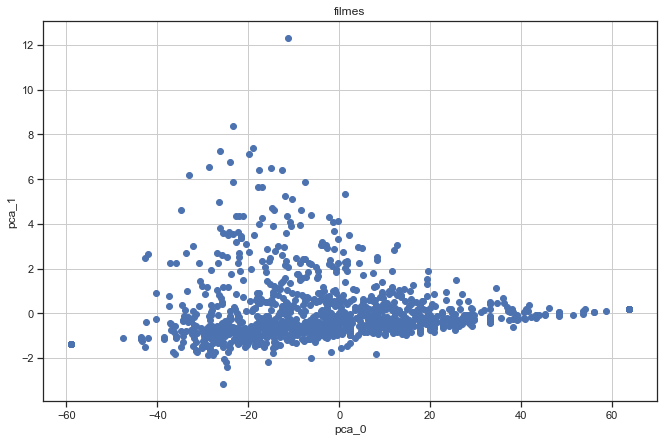

In [156]:
visualize_pca(X_pca_100k, pca_full_100k)

Observando o gráfico, percbe-se a concentração de enrgia nas primeiras componentes com apenas 3 temos que:

In [157]:
# limpando a memória
pca_full_100k = None
X_pca_100k = None

In [158]:
X_pca_100k, pca_reduced_100k = get_pca(X_train_100k, 70)

In [159]:
print("energia conservada pelas %i primeiras componentes do PCA %f" % (pca_reduced_100k.n_components, pca_reduced_100k.explained_variance_ratio_.sum())) 

energia conservada pelas 70 primeiras componentes do PCA 0.951242


In [160]:
X_test_pca_100k = pca_reduced_100k.transform(X_test_100k)

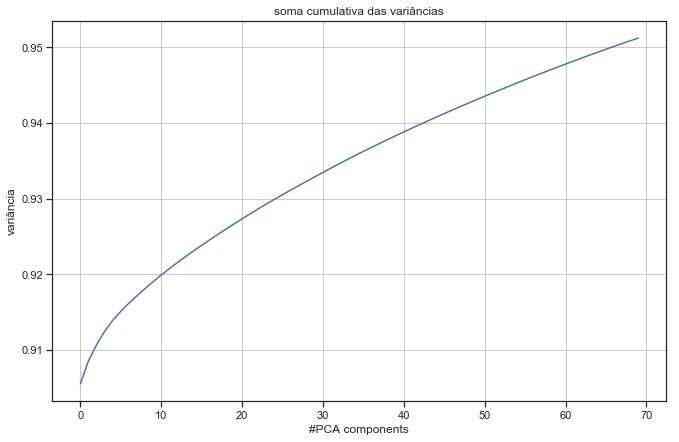

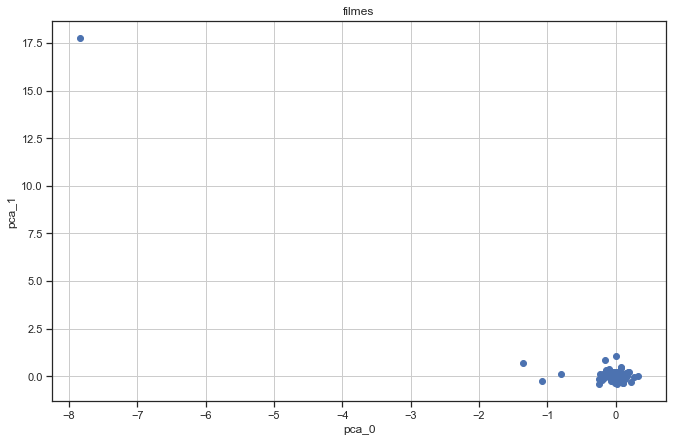

In [161]:
visualize_pca(X_test_pca_100k, pca_reduced_100k)

## PCA para a base de 1M

In [187]:
X_pca_1M, pca_full_1M = get_pca(df_features_1M_filled_avg, None)

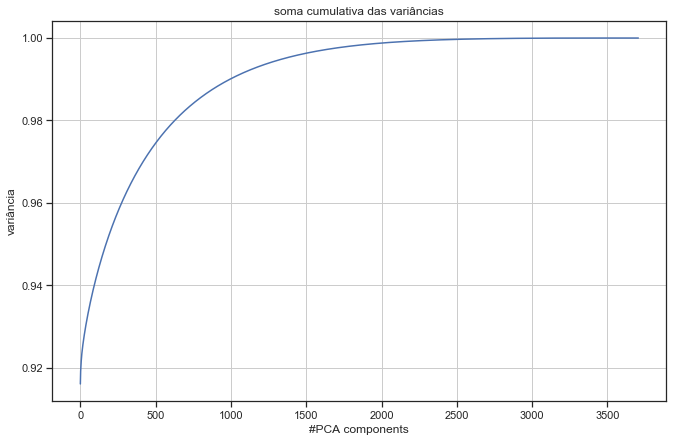

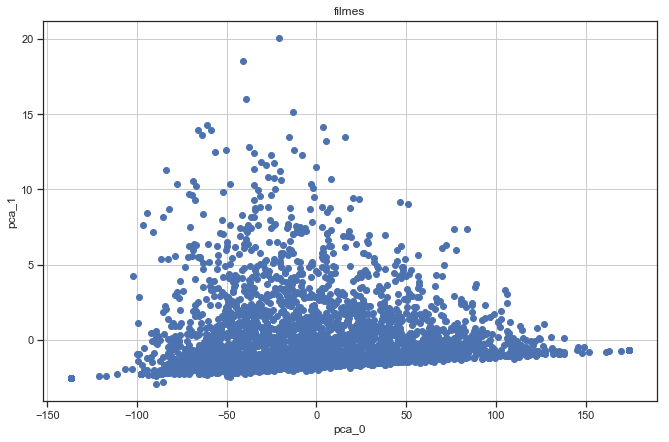

In [188]:
visualize_pca(X_pca_1M, pca_full_1M)

In [166]:
# limpando a memória
pca_full_1M = None
X_pca_1M = None

Observando o gráfico, percbe-se a concentração de enrgia nas primeiras componentes com apenas 3 temos que:

In [189]:
X_pca_Train_1M, pca_reduced_1M = get_pca(X_pca_1M, 70)

In [190]:
print("energia conservada pelas %i primeiras componentes do PCA %f" % (pca_reduced_1M.n_components, pca_reduced_1M.explained_variance_ratio_.sum())) 

energia conservada pelas 70 primeiras componentes do PCA 0.936187


## Landmarkss

Para escolher os Landmarks, vou ordená-los por ordem decrescente de ordem L) (número de componentes não 0 do vetor)

In [38]:
def visualize_lca(df):
    plt.figure(),
    g = sns.pairplot( df, x_vars=df.columns, y_vars=df.columns)
    plt.show()

In [103]:
class LandmarksComponentAnalysis:
    
    def __init__(self, num_landmarks, metric, epsilon=1e-8):
        self.n_components = num_landmarks
        self.metric_ = metric
        self.epsilon_ = epsilon
    
    def select_most_seen_as_landmarks(self, filesDF_notFilled):
        most_seen_films = filesDF_notFilled.notna().sum(axis=1).sort_values(ascending=False)
#         print(most_seen_films)
        most_seen_films_idx = most_seen_films.index
        landmarks_idx = most_seen_films_idx[0:self.n_components]
        return landmarks_idx
    
    def fit(self, sparseDF, featuresDF):
        selected_landmarks_ids = self.select_most_seen_as_landmarks(sparseDF)
        self.landmarks_ = featuresDF.loc[selected_landmarks_ids]
        return self
        
    def transform(self, data):
        self.epsilon_ = 1e-8
        
        dists = pairwise_distances(X=data, Y=self.landmarks_, metric=self.metric_)
        
        inv_dists = 1/(dists + self.epsilon_)        
#         df_transformed_values = inv_dists
        
#         normalize
        sum_invs_dists = inv_dists.sum(axis=1).reshape(-1,1)
        df_transformed_values = inv_dists/sum_invs_dists # dists.divide(dists.sum(axis=1), axis=0)
        
#         print(weights_values[0:5,:])
#         df_transformed_values = np.matmul(weights_values, self.landmarks_.values)

        df_transformed = pd.DataFrame(data=df_transformed_values)
        df_transformed.index = data.index
        
        return df_transformed

### Base 100k

In [240]:
lca_100k = LandmarksComponentAnalysis(20, 'euclidean').fit(X_train_sparse_100k, X_train_100k)

In [241]:
X_lca_train_100k = lca_100k.transform(X_train_100k)

In [242]:
landmarks_full = enrich_columns(lca_100k.landmarks_, to_enrich_100k)

Nomes do landmarks escolhidos

In [243]:
print(landmarks_full['movie_title'])

id
50                     Star Wars (1977)
258                      Contact (1997)
100                        Fargo (1996)
181           Return of the Jedi (1983)
294                    Liar Liar (1997)
286         English Patient, The (1996)
1                      Toy Story (1995)
121       Independence Day (ID4) (1996)
174      Raiders of the Lost Ark (1981)
127               Godfather, The (1972)
56                  Pulp Fiction (1994)
98     Silence of the Lambs, The (1991)
237                Jerry Maguire (1996)
117                    Rock, The (1996)
172     Empire Strikes Back, The (1980)
222     Star Trek: First Contact (1996)
313                      Titanic (1997)
204           Back to the Future (1985)
405          Mission: Impossible (1996)
79                 Fugitive, The (1993)
Name: movie_title, dtype: object


Visualizando as os calores das componentes na base

<Figure size 792x504 with 0 Axes>

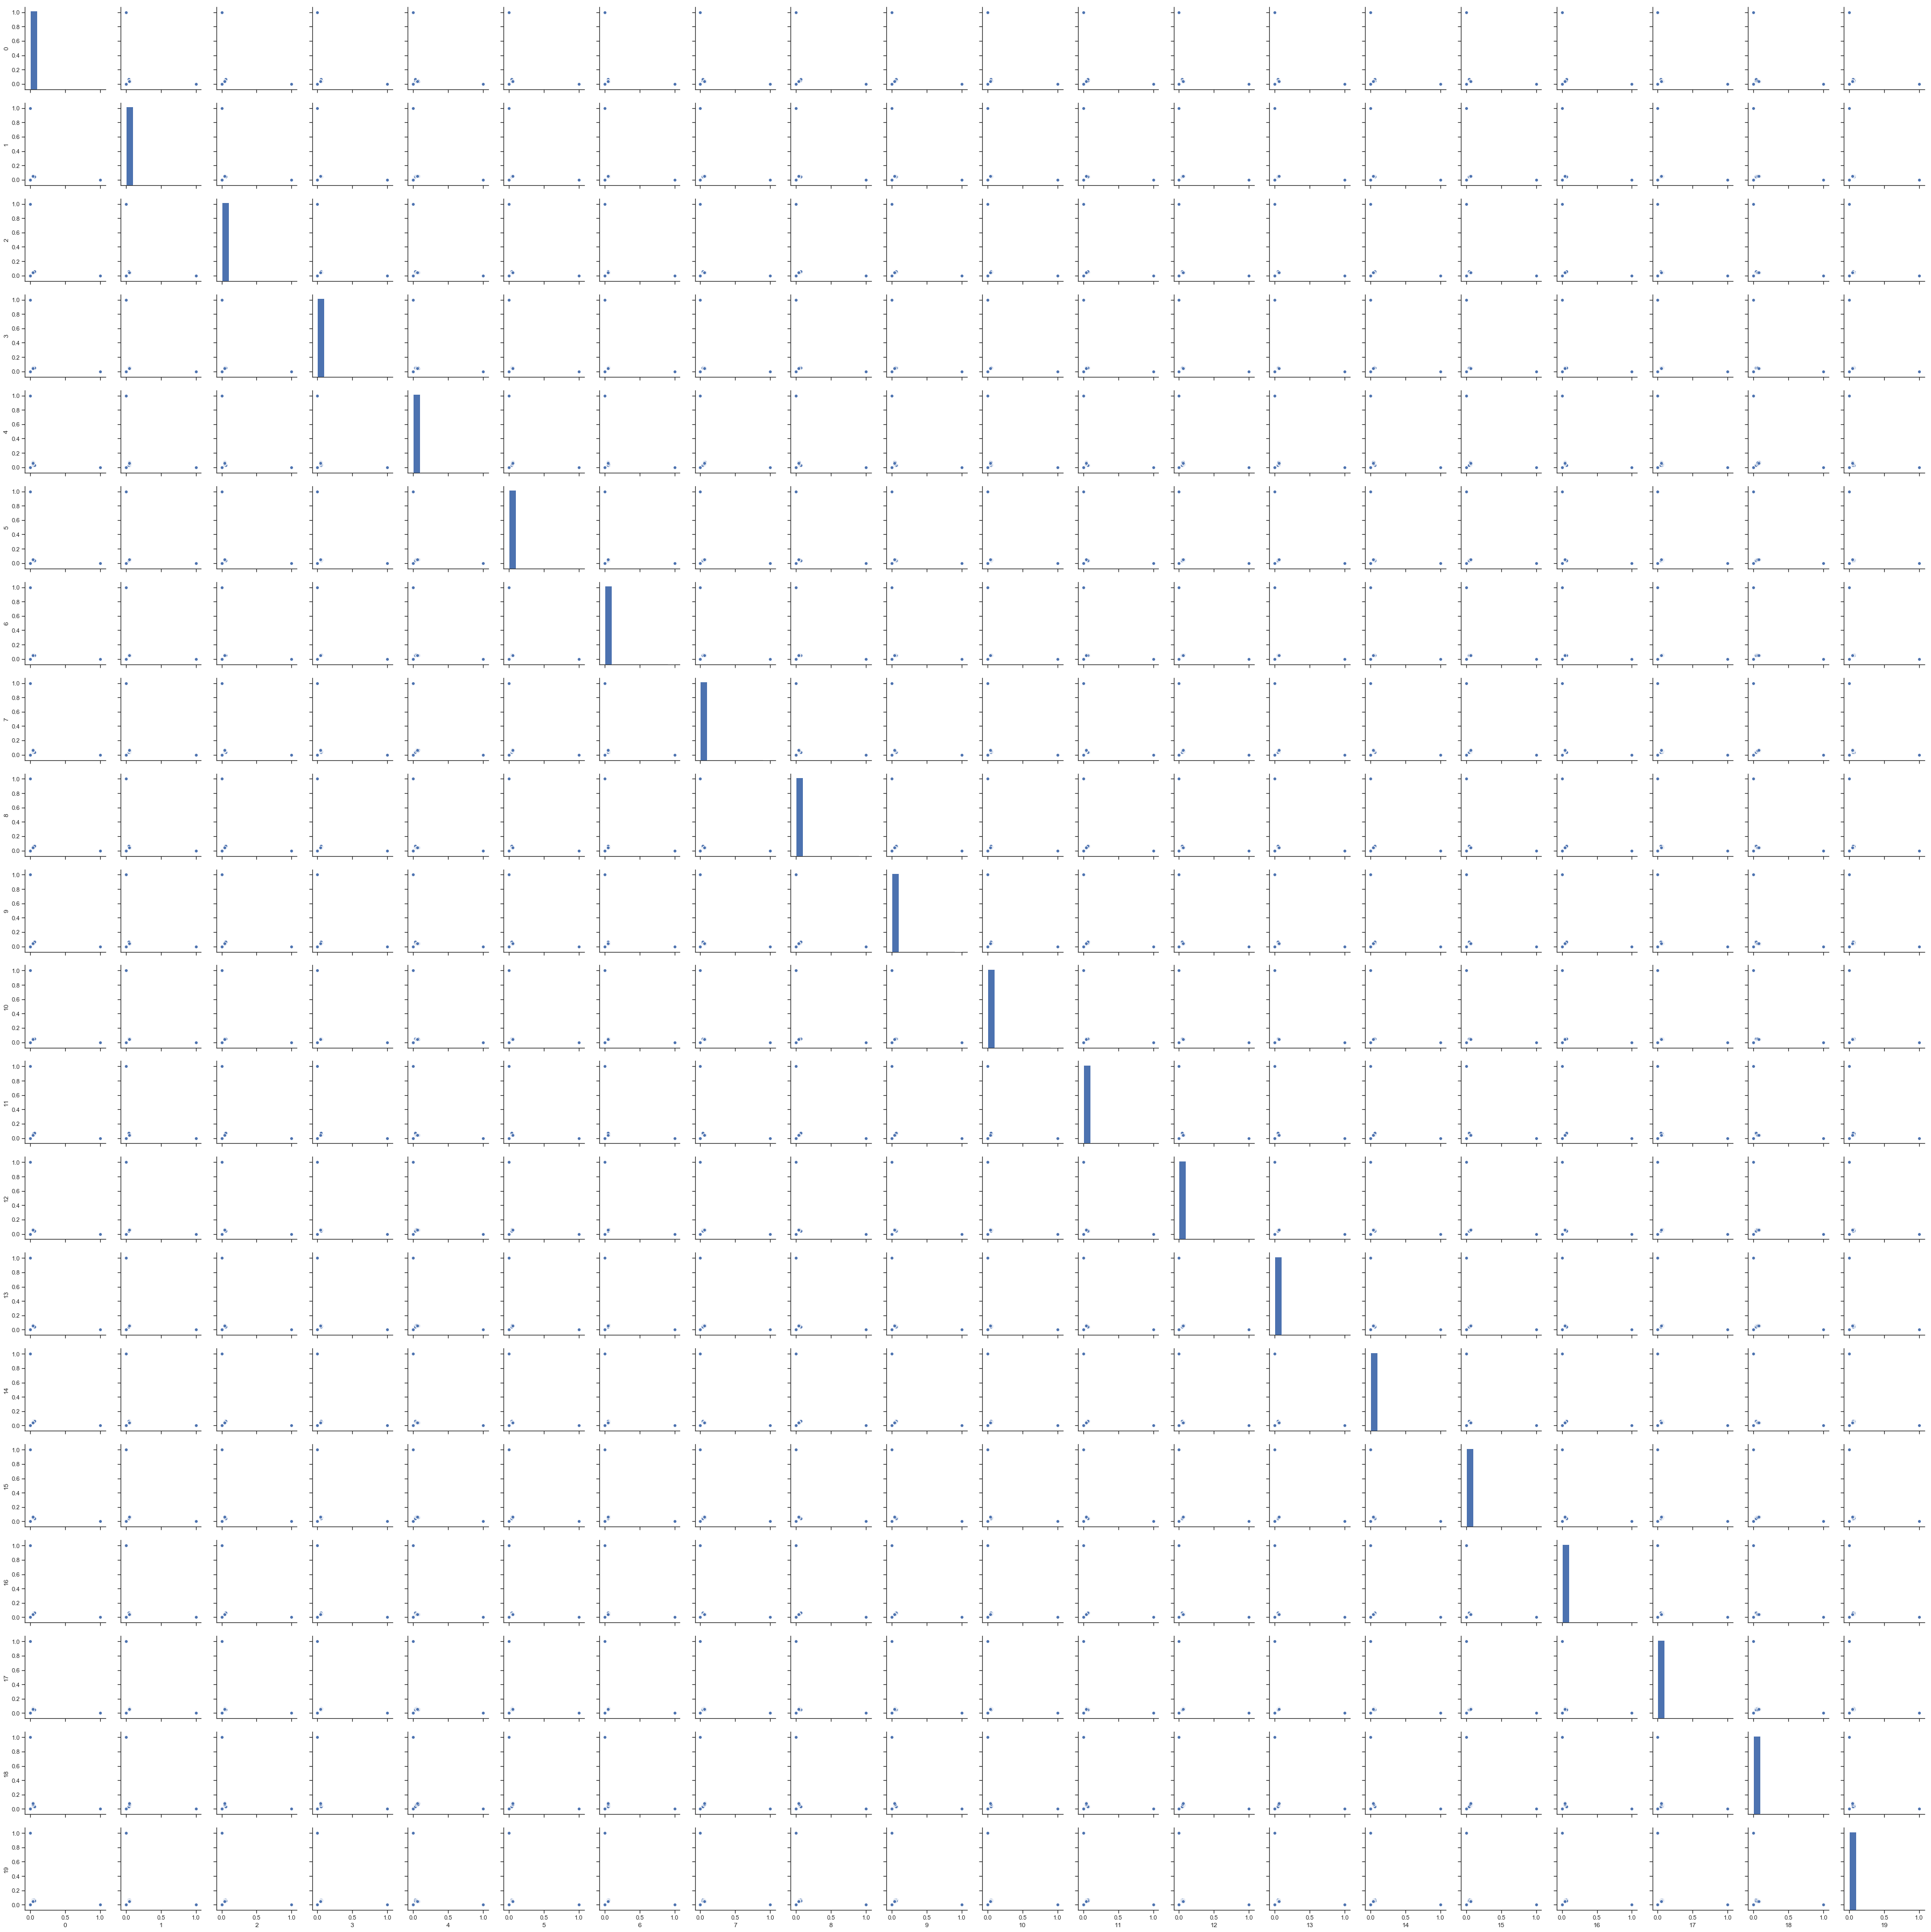

In [244]:
visualize_lca(X_lca_train_100k)

In [245]:
X_lca_test_100k = lca_100k.transform(X_test_100k)

<Figure size 792x504 with 0 Axes>

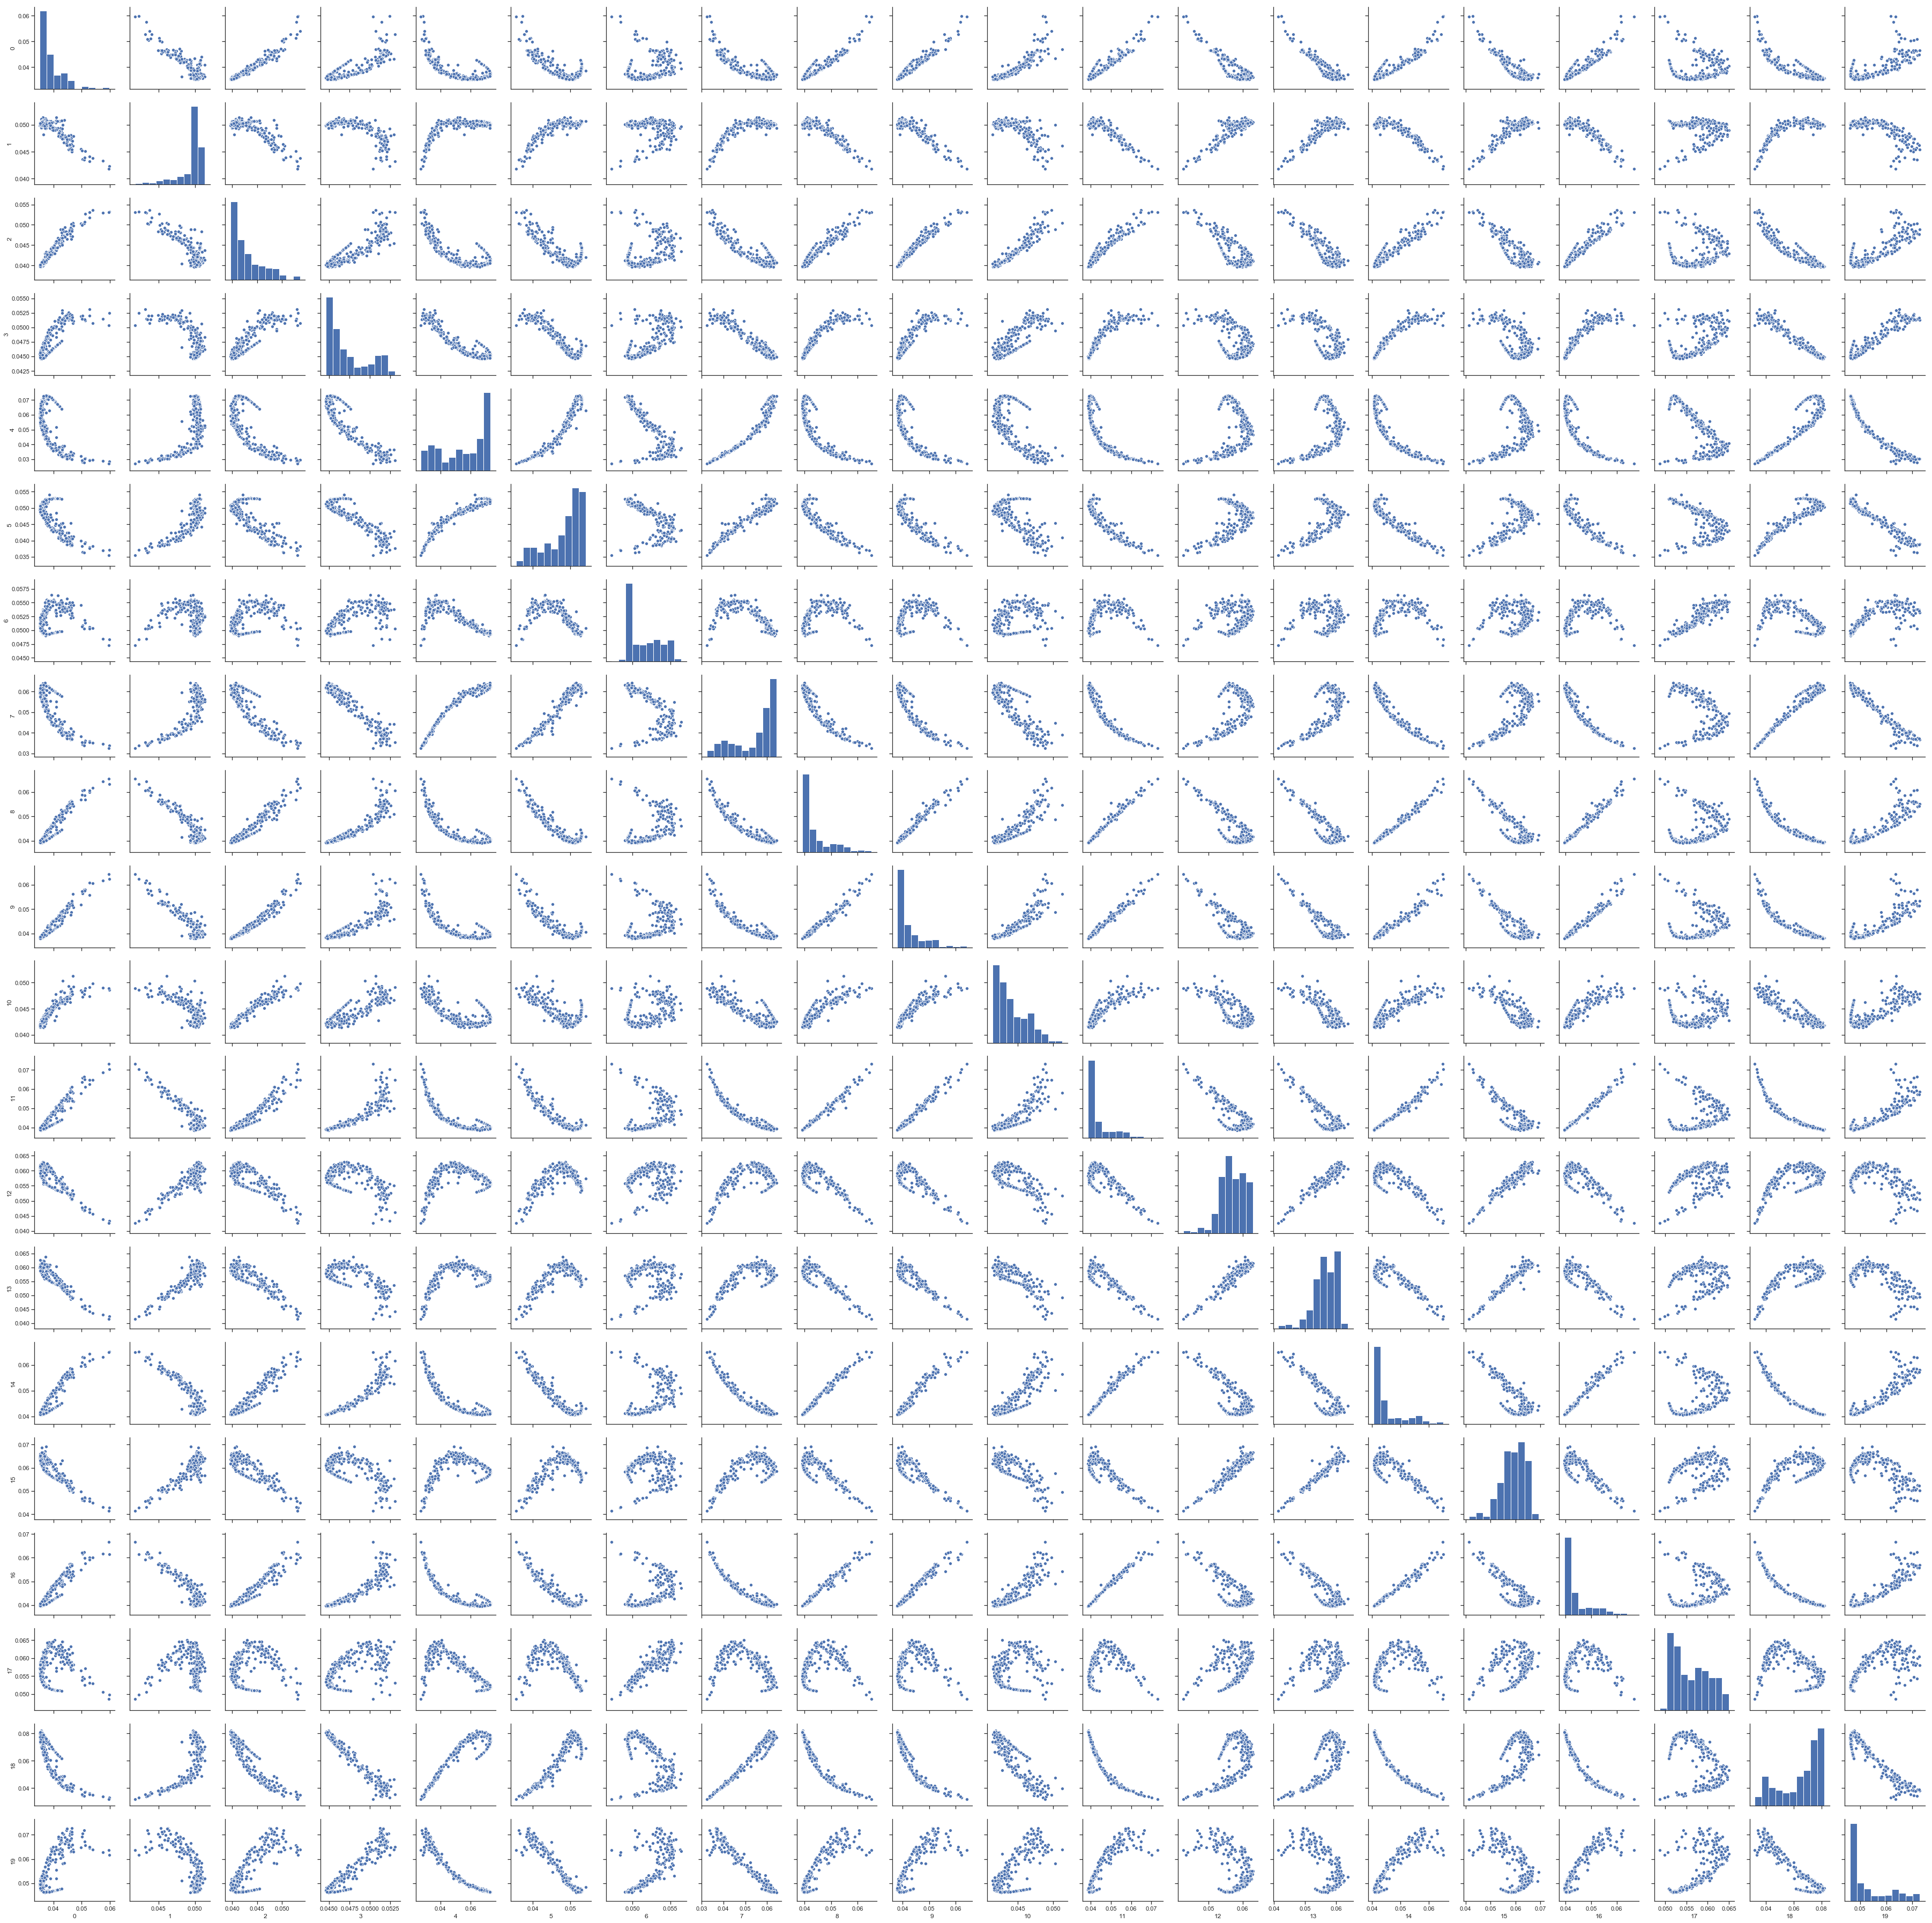

In [246]:
visualize_lca(X_lca_test_100k)

a dispersão entre teste e treino não deve ser tão diferente quanto se acredita em primeira vista, os outliers do conjuntode treino fazem a escla muito diferente

### Base 1M

In [247]:
lca_1M = LandmarksComponentAnalysis(20, 'euclidean').fit(X_train_sparse_1M, X_train_1M)

In [248]:
X_lca_train_1M = lca_1M.transform(X_train_1M)

In [249]:
landmarks_full_1M = enrich_columns(lca_1M.landmarks_, to_enrich_1M)

Nomes do landmarks escolhidos

In [250]:
print(landmarks_full_1M['movie_title'])

id
2858                               AMERICAN BEAUTY (1999)
1196    STAR WARS: EPISODE V - THE EMPIRE STRIKES BACK...
480                                  JURASSIC PARK (1993)
2028                           SAVING PRIVATE RYAN (1998)
589                     TERMINATOR 2: JUDGMENT DAY (1991)
1270                            BACK TO THE FUTURE (1985)
593                      SILENCE OF THE LAMBS, THE (1991)
1580                                  MEN IN BLACK (1997)
1198                       RAIDERS OF THE LOST ARK (1981)
608                                          FARGO (1996)
2762                              SIXTH SENSE, THE (1999)
110                                     BRAVEHEART (1995)
2396                           SHAKESPEARE IN LOVE (1998)
1197                           PRINCESS BRIDE, THE (1987)
1617                             L.A. CONFIDENTIAL (1997)
1265                                 GROUNDHOG DAY (1993)
1097                    E.T. THE EXTRA-TERRESTRIAL (1982)
318        

<Figure size 792x504 with 0 Axes>

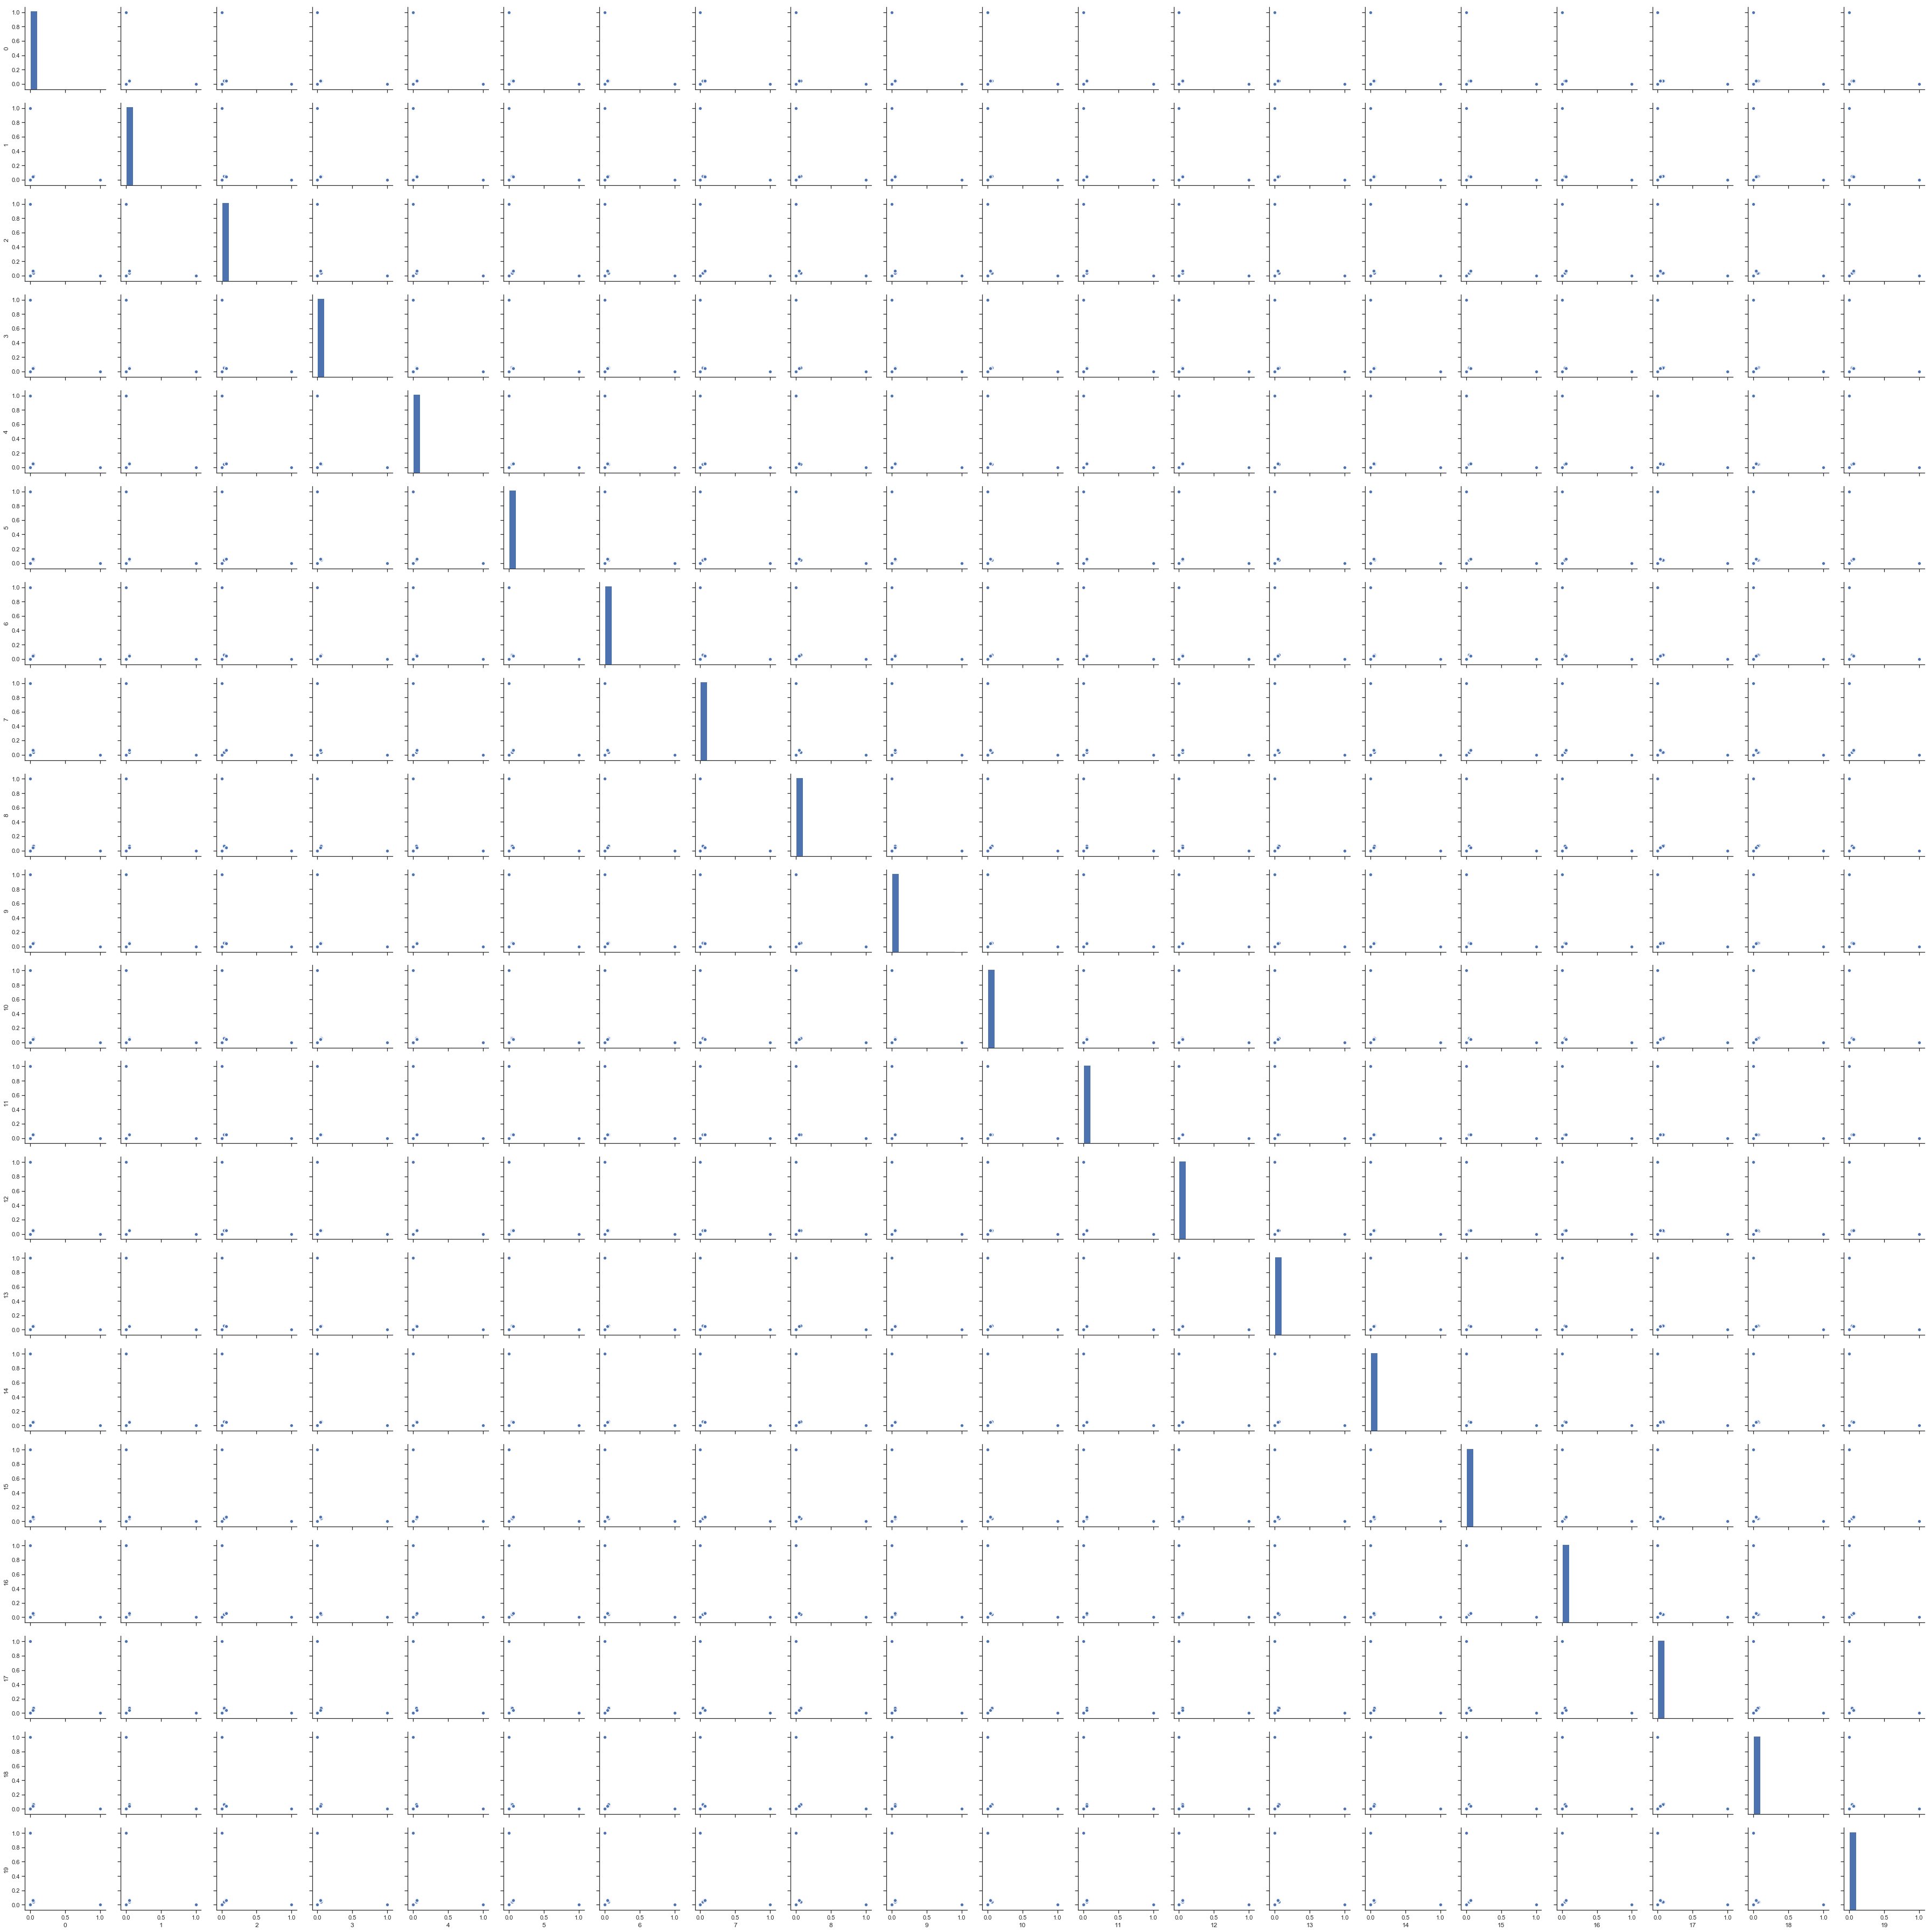

In [251]:
visualize_lca(X_lca_train_1M)

In [252]:
X_lca_test_1M = lca_1M.transform(X_test_1M)

<Figure size 792x504 with 0 Axes>

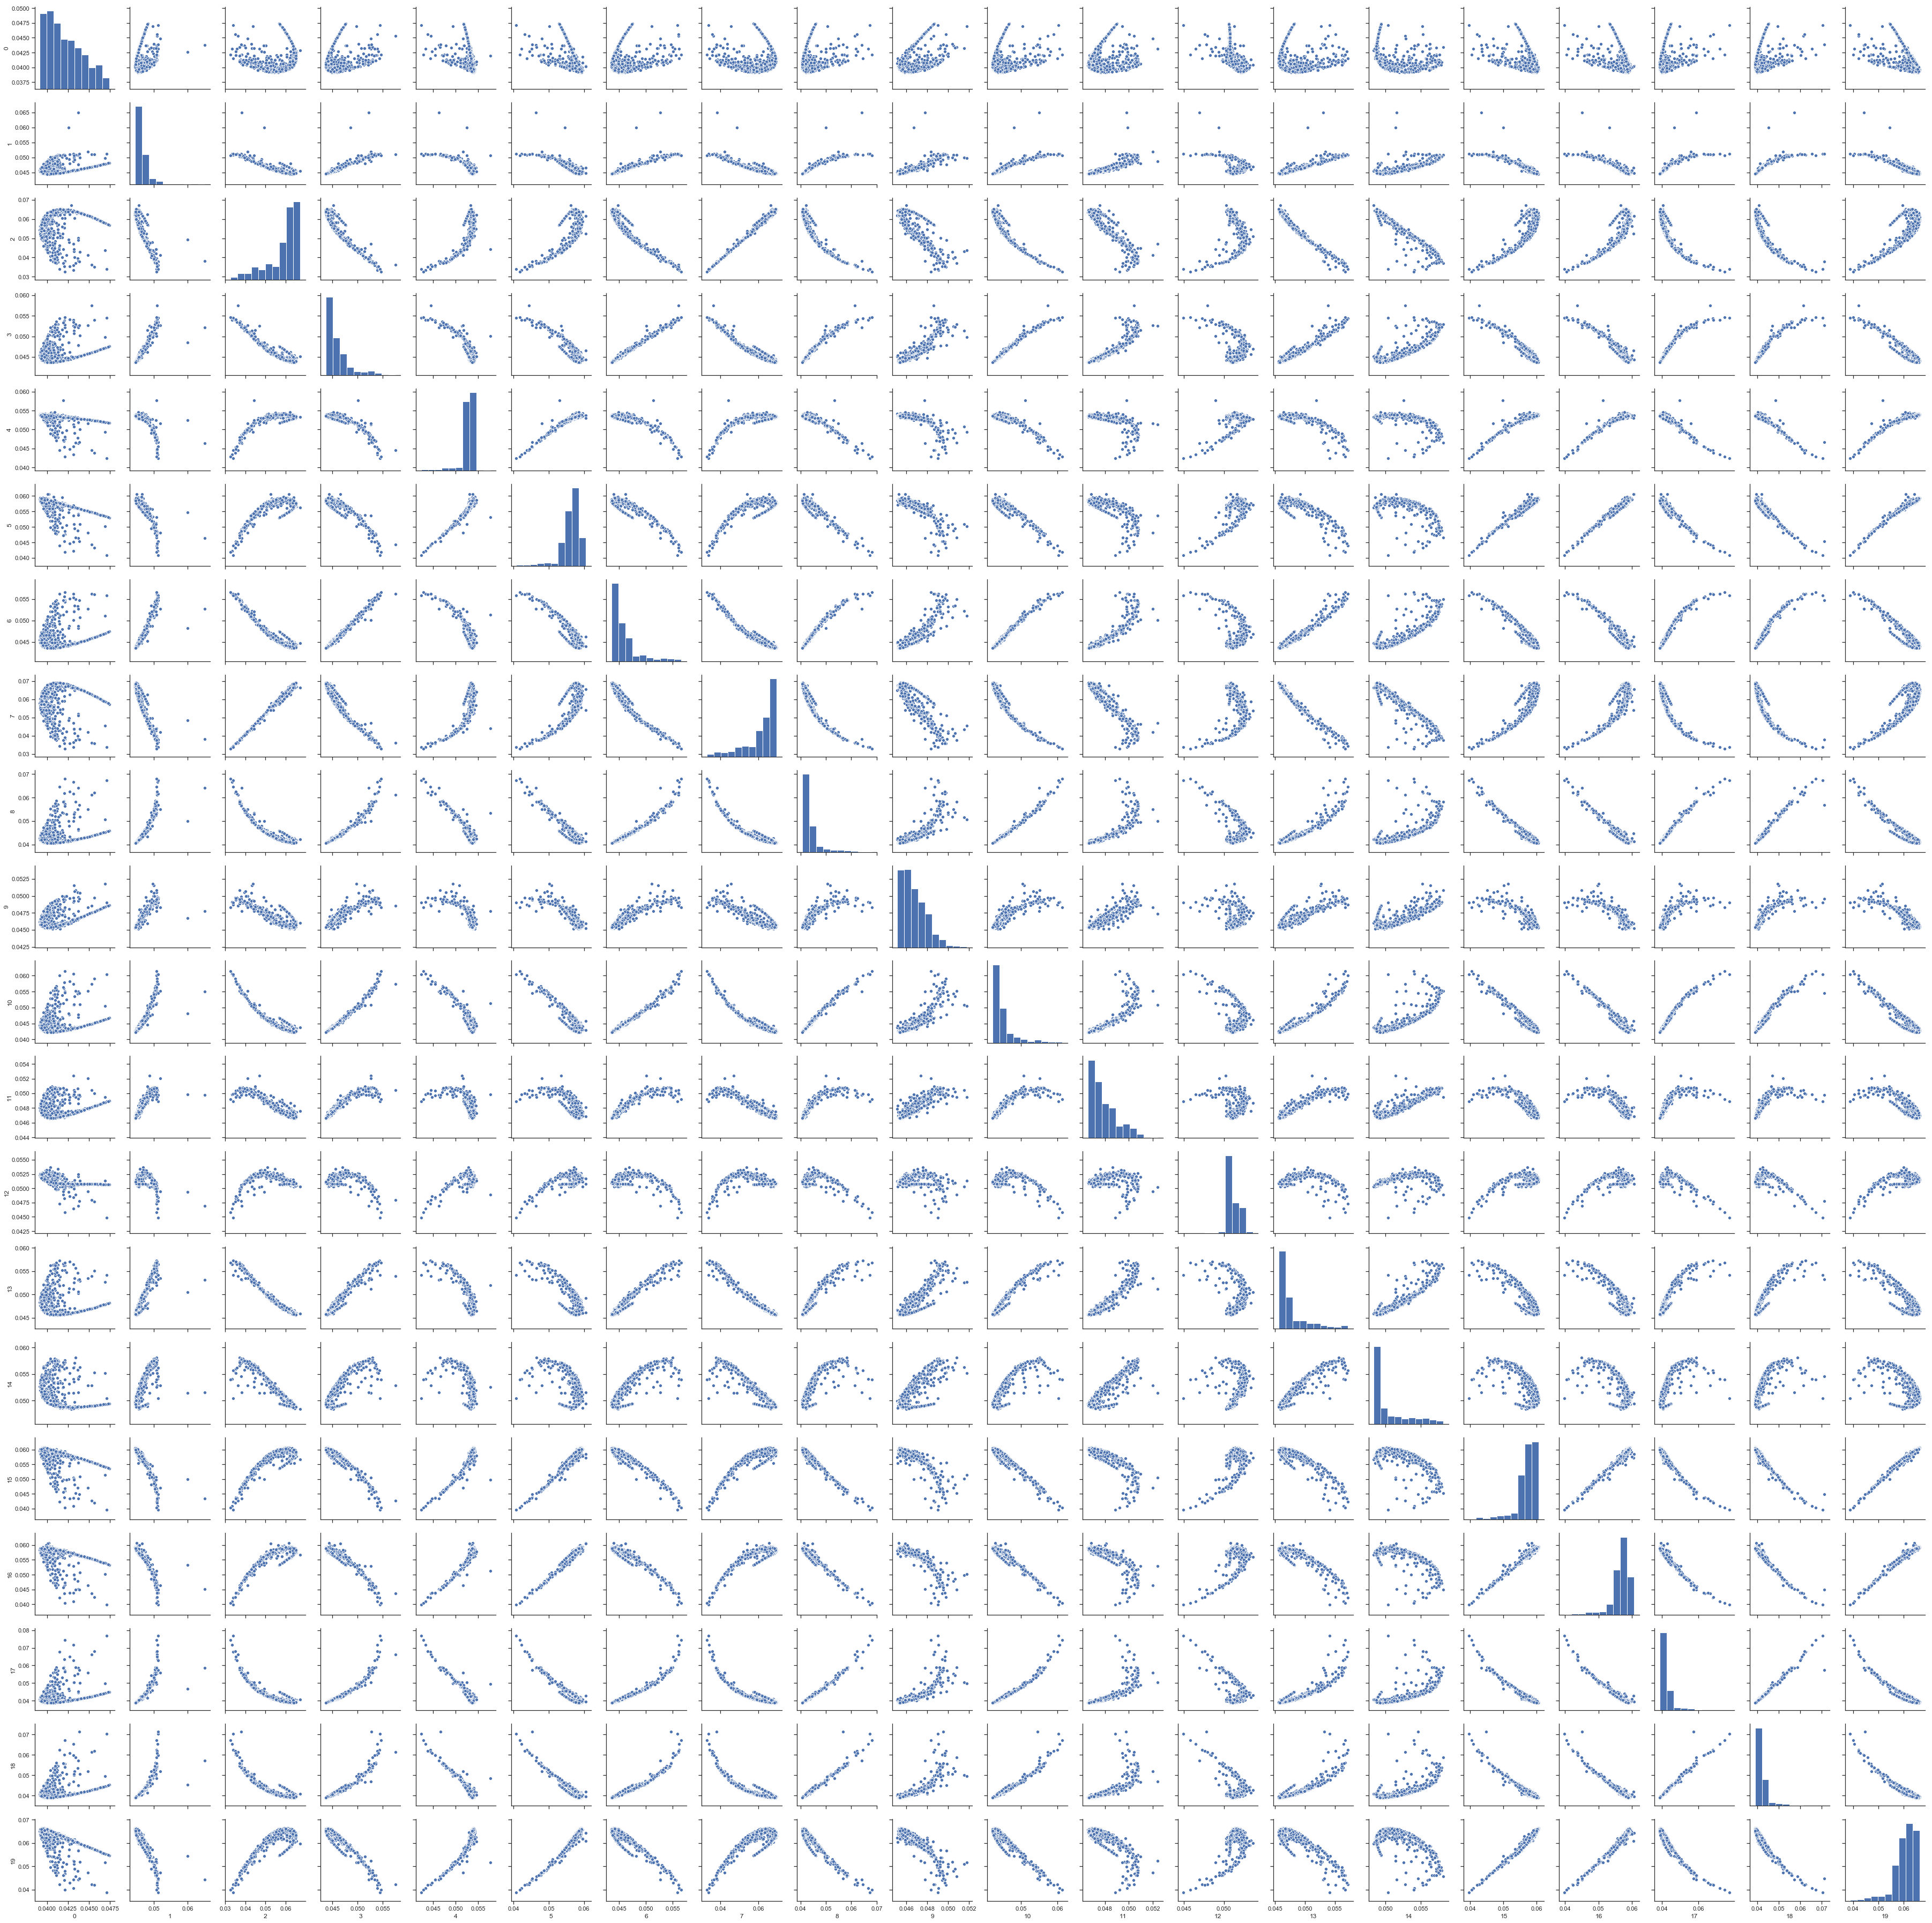

In [253]:
visualize_lca(X_lca_test_1M)

# Conclusão